In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score
import xgboost as xgb

import wrangle as wr
import explore as ex
import model as mod

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
%matplotlib inline
pd.options.display.max_columns = None

np.set_printoptions(suppress=True)

seed = 42

# acquire and prep

In [2]:
df = wr.get_heart_disease()

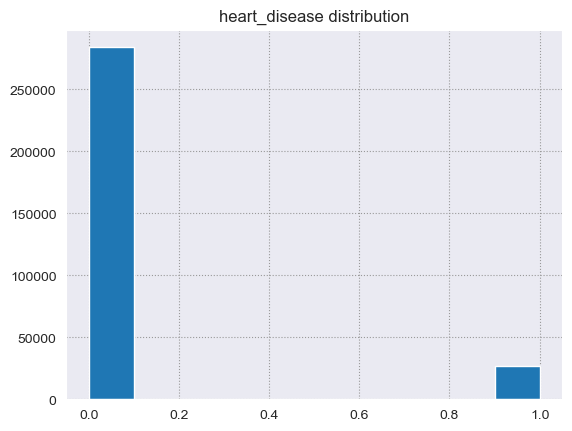

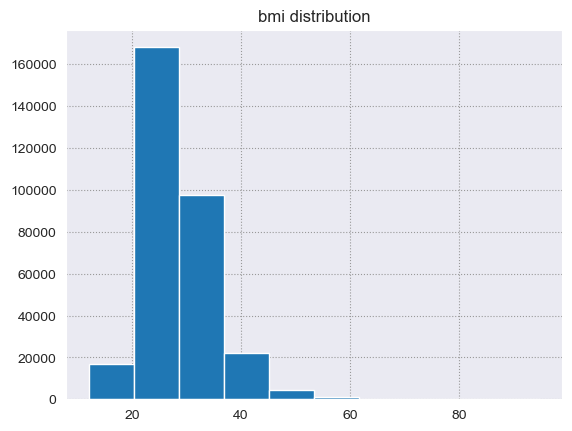

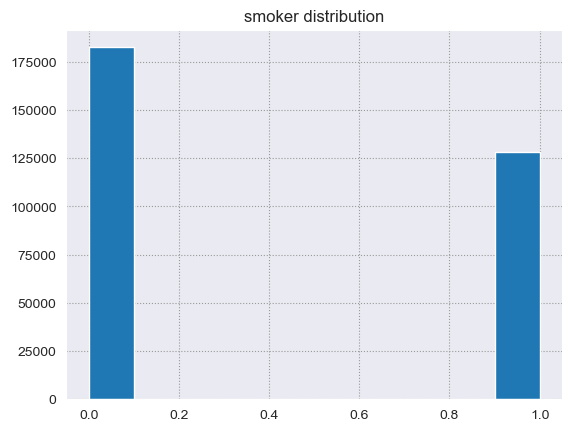

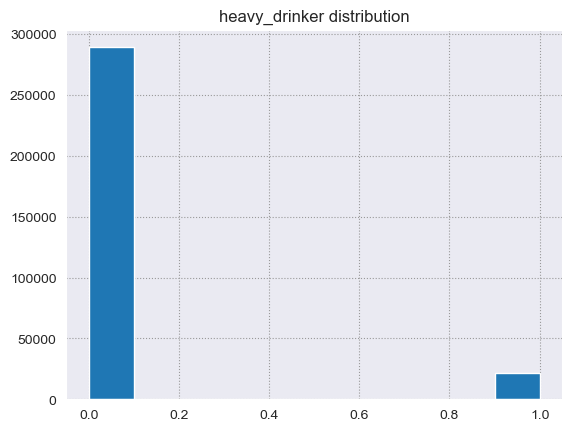

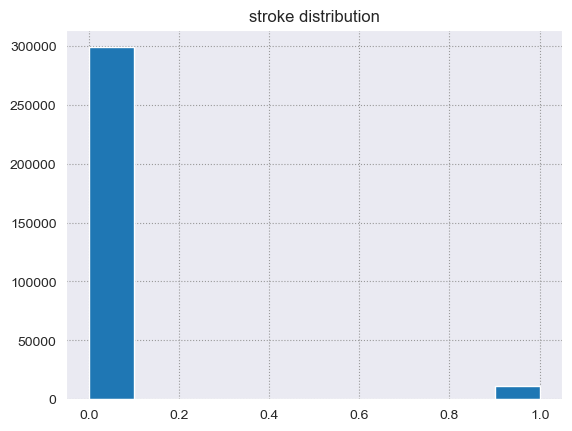

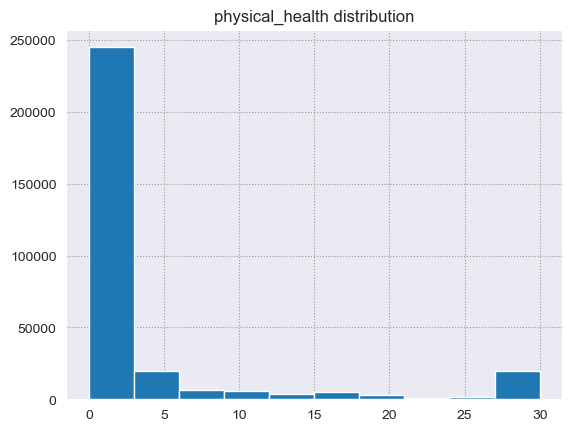

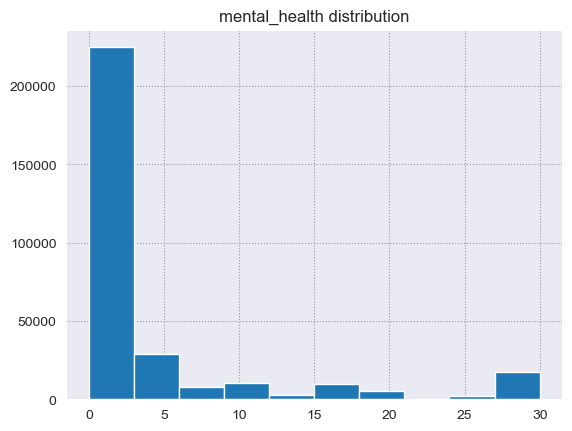

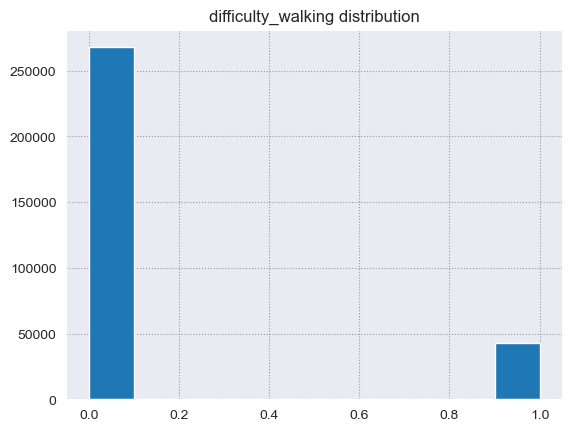

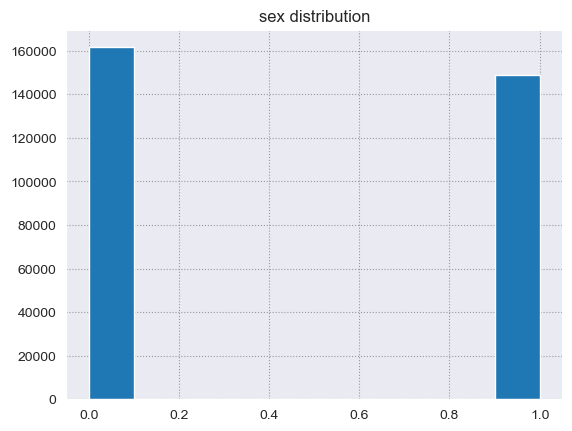

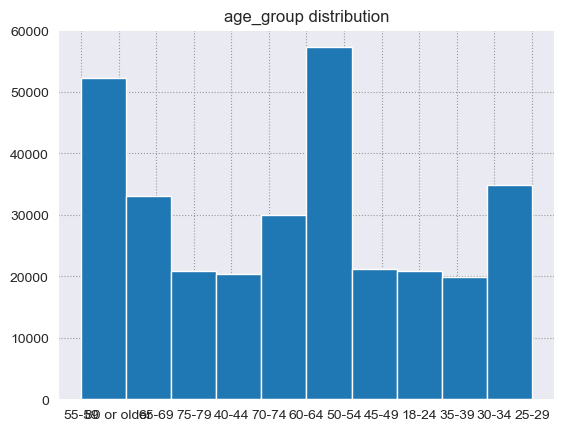

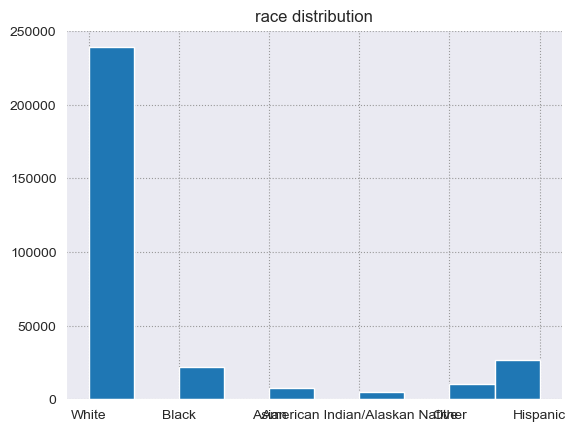

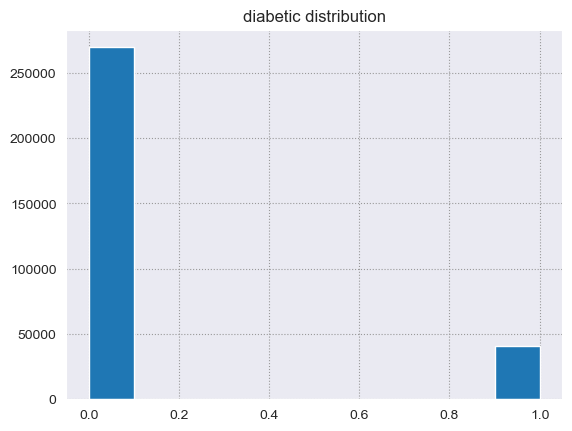

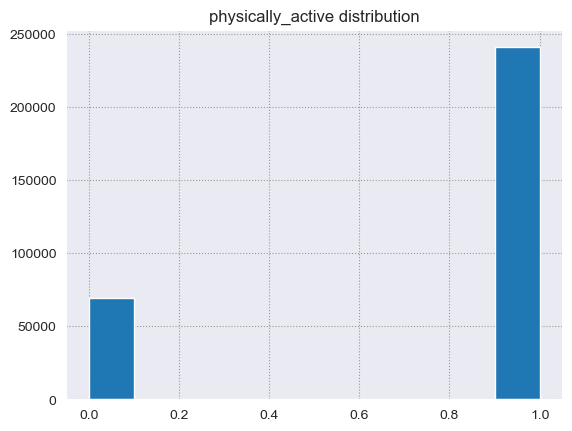

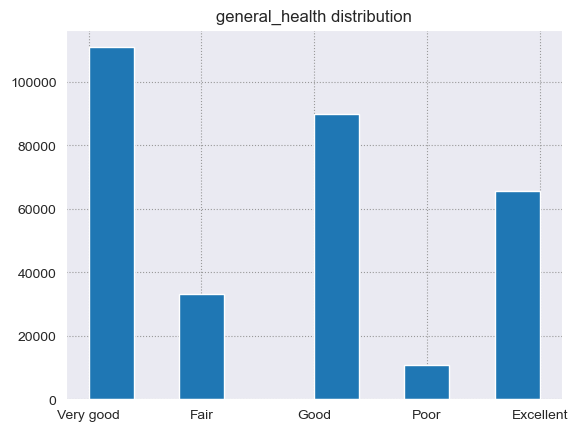

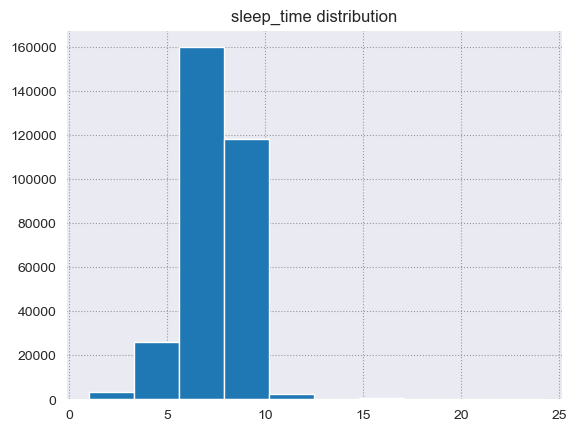

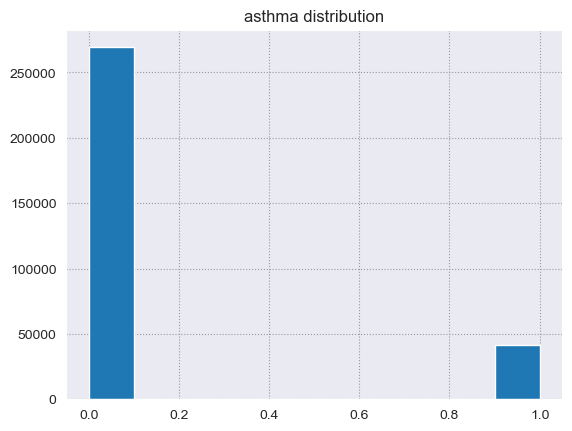

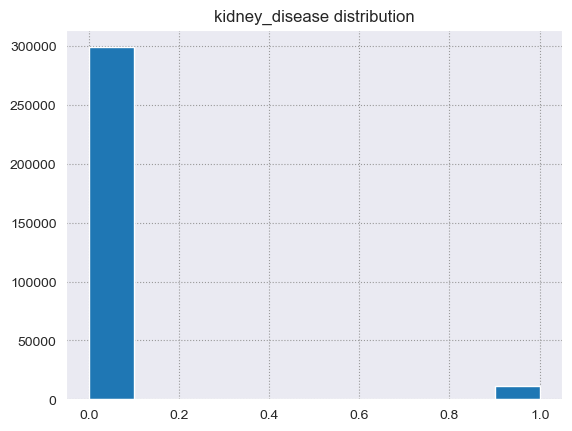

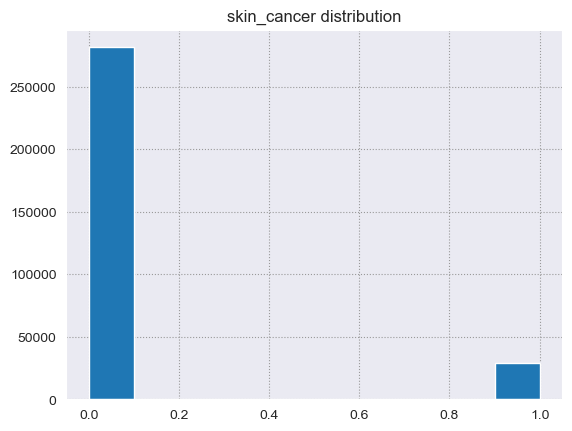

In [3]:
for col in df.columns:
    
    plt.hist(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.show()

In [4]:
#categorical data
cat = df.select_dtypes(include='object').columns
len(cat)

3

In [5]:
num = df.select_dtypes(include=np.number).columns
len(num)

15

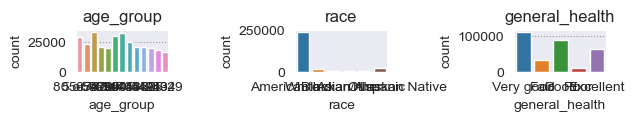

In [6]:
r=5
c=3
it=1
for i in cat:
    plt.subplot(r,c,it)
    sns.countplot(df.loc[:,i])
    #plt.xticks(rotation=90)
    plt.title(i)
    it+=1
plt.tight_layout()
plt.show()

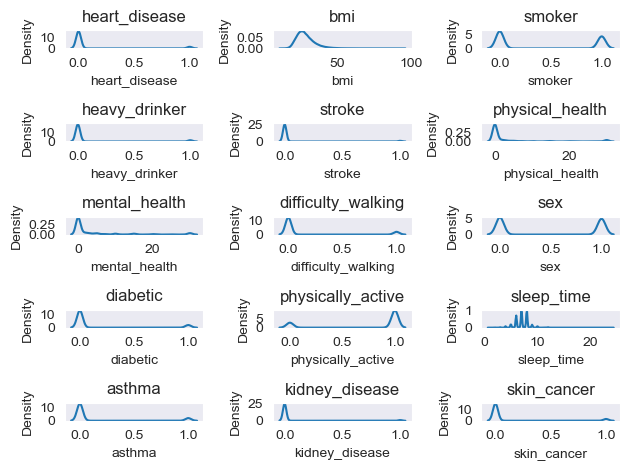

In [7]:
r=5
c=3
it=1
for i in num:
    plt.subplot(r,c,it)
    sns.distplot(df.loc[:,i],hist=False)
    plt.title(i)
    plt.grid()
    it+=1
plt.tight_layout()
plt.show()

In [8]:
df.head()

,heart_disease,bmi,smoker,heavy_drinker,stroke,physical_health,mental_health,difficulty_walking,sex,age_group,race,diabetic,physically_active,general_health,sleep_time,asthma,kidney_disease,skin_cancer
0,0,16.60,1,0,0,3.0,30.0,0,0,55-59,White,1,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,80 or older,White,0,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,65-69,White,1,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,75-79,White,0,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,40-44,White,0,1,Very good,8.0,0,0,0


In [9]:
df['age_group'] = df['age_group'].map(df['age_group'].value_counts(normalize=True))

In [10]:
encode = ['race','general_health','diabetic']

for i in encode:
    df[i] = df[i].map(df[i].value_counts(normalize=True))

In [11]:
train, validate, test = wr.subset_df(df, stratify='heart_disease')

(186273, 18) (62091, 18) (62091, 18)


In [12]:
X_train, y_train, X_validate, y_validate, X_test, y_test = mod.xy_subsets(train, validate, test, 'heart_disease')

In [13]:
cols = ['bmi', 'physical_health', 'mental_health', 'sleep_time']

train_scaled, validate_scaled, test_scaled = wr.scale_data(train, validate, test, MinMaxScaler(), cols)

In [14]:
baseline = mod.make_baseline(df, 'baseline', 'heart_disease')

Baseline Accuracy is: 0.915


In [15]:
xc = sm.add_constant(X_train)
xc.head()

,const,bmi,smoker,heavy_drinker,stroke,physical_health,mental_health,difficulty_walking,sex,age_group,race,diabetic,physically_active,general_health,sleep_time,asthma,kidney_disease,skin_cancer
131247,1.0,27.44,0,0,0,30.0,0.0,0,0,0.067047,0.769619,0.868574,1,0.107152,8.0,1,0,0
70916,1.0,22.05,1,0,0,0.0,0.0,0,1,0.075232,0.769619,0.868574,1,0.289366,6.0,0,0,1
208380,1.0,22.14,0,0,0,10.0,0.0,0,0,0.065568,0.769619,0.868574,0,0.107152,6.0,0,0,0
312277,1.0,29.95,1,1,0,0.0,0.0,0,0,0.079316,0.769619,0.868574,0,0.289366,7.0,0,0,0
242158,1.0,28.25,1,0,0,7.0,2.0,1,0,0.079316,0.071299,0.868574,0,0.289366,9.0,1,0,0


In [16]:
model = sm.Logit(y_train,xc).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.244498
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          heart_disease   No. Observations:               186273
Model:                          Logit   Df Residuals:                   186255
Method:                           MLE   Df Model:                           17
Date:                Tue, 14 Feb 2023   Pseudo R-squ.:                  0.1613
Time:                        16:36:43   Log-Likelihood:                -45543.
converged:                       True   LL-Null:                       -54301.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.1596      0.088    -35.771      0.000      -3.333      -2.986
bmi  

In [17]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

model_list = [lr,dt,rf,knn]

train_acc = []
validate_acc = []

for i in model_list:
    i_model = i.fit(X_train,y_train)
    y_train_pred = i_model.predict(X_train)
    y_validate_pred = i_model.predict(X_validate)
    train_acc.append(accuracy_score(y_train,y_train_pred))
    validate_acc.append(accuracy_score(y_validate,y_validate_pred))


In [18]:
models = ['Logistic Regression','Decision Tree Classifier','Random Forest Classifier','KNeighbors Classifier']

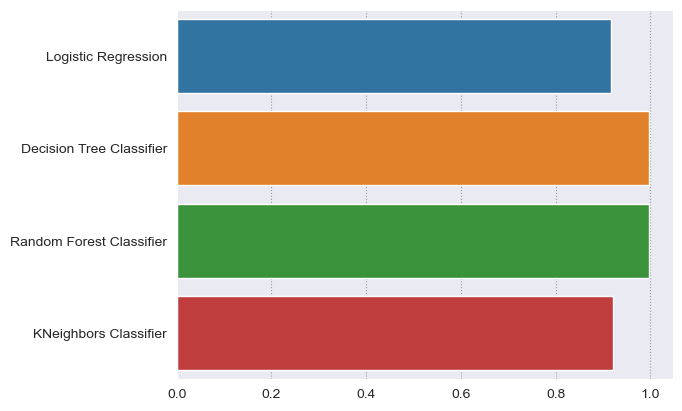

In [19]:
sns.barplot(y=models,x=train_acc)
plt.show()

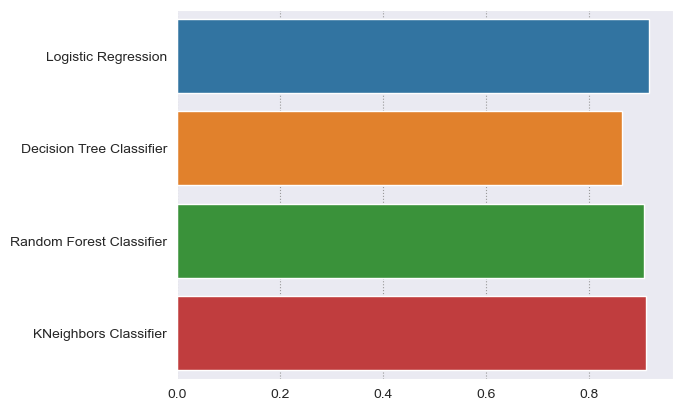

In [20]:
sns.barplot(y=models,x=validate_acc)
plt.show()

In [49]:
def basic_models(X_train, y_train):

    lr = LogisticRegression()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()

    model_list = [lr,dt,rf,knn]

    train_acc = []
    validate_acc = []

    for i in model_list:
        
        i_model = i.fit(X_train,y_train)
        y_train_pred = i_model.predict(X_train)
        y_validate_pred = i_model.predict(X_validate)
        train_acc.append(accuracy_score(y_train,y_train_pred))
        validate_acc.append(accuracy_score(y_validate,y_validate_pred))
    
    plt.subplot(1, 2, 1)
    sns.barplot(y=models,x=train_acc)
    
    plt.subplot(1, 2, 2)
    sns.barplot(y=models,x=validate_acc)
    plt.show()

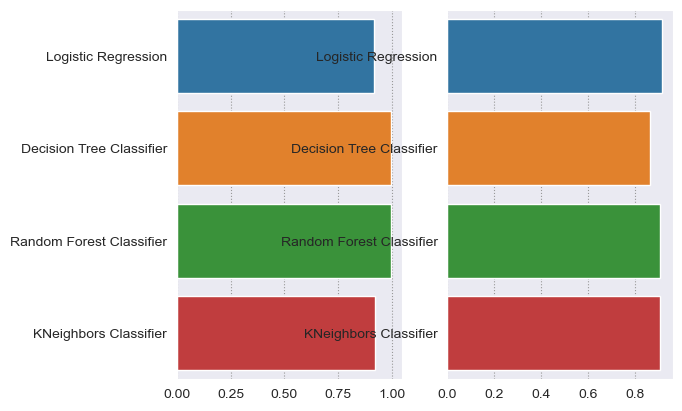

In [50]:
basic_models(X_train, y_train)

In [21]:
for n in range(1,11):

    rf = RandomForestClassifier(max_depth=n, min_samples_split=3)

    rf_model = rf.fit(X_train, y_train)

    model = rf.fit(X_train, y_train)
    validate_pred = rf.predict(X_validate)

    print(accuracy_score(y_validate, validate_pred))

0.9153661561256865
0.9153661561256865
0.9153661561256865
0.9155916316374354
0.915994266479844
0.9162519527789856
0.9163163743537711
0.9163807959285565
0.916268058172682
0.9163969013222528


In [42]:
rf = RandomForestClassifier(max_depth=6, min_samples_split=3, random_state=seed)

rf_model = rf.fit(X_train, y_train)

model = rf.fit(X_train, y_train)
validate_pred = rf.predict(X_validate)

print(accuracy_score(y_validate, validate_pred))

0.9160425826609332


In [43]:
rf = RandomForestClassifier(max_depth=7, min_samples_split=3, random_state=seed)

rf_model = rf.fit(X_train, y_train)

model = rf.fit(X_train, y_train)
validate_pred = rf.predict(X_validate)

print(accuracy_score(y_validate, validate_pred))

0.9162841635663784


plotting feature importances

In [27]:
def plot_feature_imp(X_train, y_train):
    
    seed=42
    
    rf = RandomForestClassifier()
    rf_model = rf.fit(X_train, y_train)
    rf_model.feature_importances_
    
    importances = pd.DataFrame(X_train.columns, columns=['features'])
    importances['feature_importances'] = rf_model.feature_importances_
    imp = importances.sort_values(by='feature_importances', ascending=False)
    
    sns.barplot(y=imp['features'], x=imp['feature_importances'])
    
    plt.show()

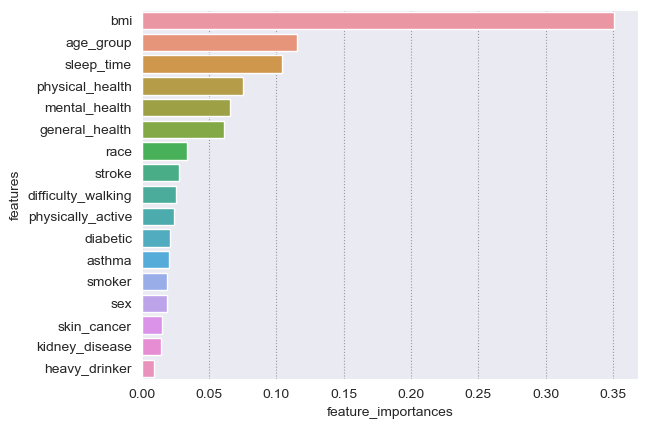

In [28]:
plot_feature_imp(X_train, y_train)

In [29]:
imp['features'][0:7].values

array(['general_health', 'stroke', 'age_group', 'difficulty_walking',
       'diabetic', 'physical_health', 'kidney_disease'], dtype=object)

In [30]:
imp['features'][7:].values

array(['sex', 'smoker', 'skin_cancer', 'bmi', 'race', 'sleep_time',
       'mental_health', 'physically_active', 'asthma', 'heavy_drinker'],
      dtype=object)

X_train = X_train.drop(columns=['physical_health', 'smoker', 'skin_cancer', 'bmi', 'race',
       'sleep_time', 'mental_health', 'physically_active', 'asthma',
       'heavy_drinker'])
X_validate = X_validate.drop(columns=['physical_health', 'smoker', 'skin_cancer', 'bmi', 'race',
       'sleep_time', 'mental_health', 'physically_active', 'asthma',
       'heavy_drinker'])
X_test = X_test.drop(columns=['physical_health', 'smoker', 'skin_cancer', 'bmi', 'race',
       'sleep_time', 'mental_health', 'physically_active', 'asthma',
       'heavy_drinker'])

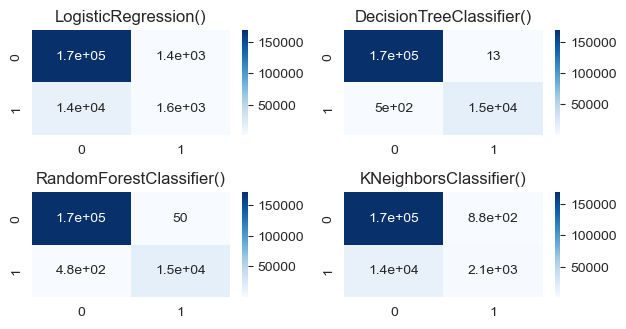

In [31]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

model_list = [lr,dt,rf,knn]


r=3
c=2
it=1
for i in model_list:
    
    i_model = i.fit(X_train,y_train)
    y_train_pred = i_model.predict(X_train)
    y_validate_pred = i_model.predict(X_validate)
    plt.subplot(r,c,it)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),annot=True, cmap='Blues')
    plt.title(i)
    it+=1
plt.tight_layout()
plt.show()

In [32]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()


model_dict = {'Model':model_list,'Train Score':train_acc,'Validate Score':validate_acc}
model_dict

{'Model': [LogisticRegression(),
  DecisionTreeClassifier(),
  RandomForestClassifier(),
  KNeighborsClassifier()],
 'Train Score': [0.9159513187633205,
  0.9972245038196625,
  0.9971708191740081,
  0.9210567285650632],
 'Validate Score': [0.9163646905348601,
  0.8630236266125525,
  0.9073939862459938,
  0.9096165305760899]}

In [33]:
model_summary = pd.DataFrame({'Model':model_list,'Train Score':train_acc,'Validate Score':validate_acc})
model_summary

,Model,Train Score,Validate Score
0,LogisticRegression(),0.915951,0.916365
1,DecisionTreeClassifier(),0.997225,0.863024
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.997171,0.907394
3,KNeighborsClassifier(),0.921057,0.909617


### xgboost model

In [34]:
def xg_boost1(X_train, y_train, X_validate, y_validate, X_test, y_test, max_depth, scale_pos_weight, learning_rate):
    results = []
    for md in max_depth:
        for sw in scale_pos_weight:
            for lr in learning_rate:
                clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                            random_state=42,
                                            max_depth=md,
                                            scale_pos_weight=sw,
                                            learning_rate=lr,
                                            subsample=.9,
                                            colsample_bytree=.5,
                                            n_jobs=10)
                clf_xgb.fit(X_train, y_train, verbose=False)
                # Accuracy and recall for the training data
                y_train_pred = clf_xgb.predict(X_train)
                train_accuracy = accuracy_score(y_train, y_train_pred)
                train_recall = recall_score(y_train, y_train_pred)
                # Accuracy and recall for the validate data
                y_validate_pred = clf_xgb.predict(X_validate)
                validate_accuracy = accuracy_score(y_validate, y_validate_pred)
                validate_recall = recall_score(y_validate, y_validate_pred)
                # Accuracy and recall for the test data
                y_test_pred = clf_xgb.predict(X_test)
                test_accuracy = accuracy_score(y_test, y_test_pred)
                test_recall = recall_score(y_test, y_test_pred)
                # Append results to the list
                results.append({'scale_pos_weight': sw,
                                'learning_rate': lr,
                                'max_depth': md,
                                'Train Accuracy': train_accuracy,
                                'Train Recall': train_recall,
                                'Validate Accuracy': validate_accuracy,
                                'Validate Recall': validate_recall,
                                'Test Accuracy': test_accuracy,
                                'Test Recall': test_recall})
                # Print results
                print(f"max_depth: {md}, scale_pos_weight: {sw}, learning_rate: {lr}, Train Recall: {train_recall:.4f}, Validate Recall: {validate_recall:.4f}, Test Recall: {test_recall:.4f}")
    # Convert results list to DataFrame and return
    results_df = pd.DataFrame(results)
    return results_df

In [35]:
max_depth = [4, 5, 6]
scale_pos_weight = [2, 3, 4]
learning_rate = [.1, .05, .01]

results_df = xg_boost1(X_train, y_train, X_validate, y_validate, X_test, y_test, max_depth, scale_pos_weight, learning_rate)

max_depth: 4, scale_pos_weight: 2, learning_rate: 0.1, Train Recall: 0.2615, Validate Recall: 0.2436, Test Recall: 0.2488
max_depth: 4, scale_pos_weight: 2, learning_rate: 0.05, Train Recall: 0.2154, Validate Recall: 0.2042, Test Recall: 0.2068
max_depth: 4, scale_pos_weight: 2, learning_rate: 0.01, Train Recall: 0.0961, Validate Recall: 0.0839, Test Recall: 0.0913
max_depth: 4, scale_pos_weight: 3, learning_rate: 0.1, Train Recall: 0.3943, Validate Recall: 0.3716, Test Recall: 0.3806
max_depth: 4, scale_pos_weight: 3, learning_rate: 0.05, Train Recall: 0.3473, Validate Recall: 0.3336, Test Recall: 0.3341
max_depth: 4, scale_pos_weight: 3, learning_rate: 0.01, Train Recall: 0.2058, Validate Recall: 0.1960, Test Recall: 0.1931
max_depth: 4, scale_pos_weight: 4, learning_rate: 0.1, Train Recall: 0.4996, Validate Recall: 0.4784, Test Recall: 0.4881
max_depth: 4, scale_pos_weight: 4, learning_rate: 0.05, Train Recall: 0.4568, Validate Recall: 0.4362, Test Recall: 0.4506
max_depth: 4, scale

In [36]:
results_df

,scale_pos_weight,learning_rate,max_depth,Train Accuracy,Train Recall,Validate Accuracy,Validate Recall,Test Accuracy,Test Recall
0,2,0.10,4,0.911351,0.261518,0.909584,0.243578,0.908650,0.248828
1,2,0.05,4,0.913546,0.215383,0.912822,0.204186,0.911420,0.206825
2,2,0.01,4,0.916515,0.096110,0.916236,0.083920,0.915350,0.091318
3,3,0.10,4,0.895981,0.394260,0.893656,0.371646,0.893125,0.380649
4,3,0.05,4,0.901016,0.347306,0.900034,0.333587,0.897763,0.334146
5,3,0.01,4,0.911721,0.205753,0.911920,0.196004,0.909729,0.193137
6,4,0.10,4,0.875795,0.499622,0.873508,0.478402,0.872252,0.488093
7,4,0.05,4,0.882151,0.456760,0.879725,0.436156,0.879870,0.450591
8,4,0.01,4,0.900141,0.309101,0.899969,0.301047,0.898278,0.305644
9,2,0.10,5,0.912478,0.273729,0.909343,0.244910,0.908602,0.252578


In [37]:
#for n in range(1, 11):

# Init classifier
xgb_cl = clf_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=6,
                                     scale_pos_weight=4, learning_rate=.10, subsample=.9,
                                     colsample_bytree=.5, n_jobs=10)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_validate)
    
print(classification_report(y_validate, preds))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     56836
           1       0.33      0.48      0.39      5255

    accuracy                           0.87     62091
   macro avg       0.64      0.70      0.66     62091
weighted avg       0.90      0.87      0.88     62091



In [38]:
test_preds = xgb_cl.predict(X_test)

print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     56758
           1       0.33      0.50      0.40      5333

    accuracy                           0.87     62091
   macro avg       0.64      0.70      0.66     62091
weighted avg       0.90      0.87      0.88     62091



### logistic regression models

In [39]:
lr = LogisticRegression(solver='liblinear', random_state=seed)

train_acc = []
validate_acc = []

model = lr.fit(X_train, y_train)
validate_pred = lr.predict(X_validate)

print(classification_report(y_validate, validate_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56836
           1       0.53      0.09      0.15      5255

    accuracy                           0.92     62091
   macro avg       0.73      0.54      0.55     62091
weighted avg       0.89      0.92      0.89     62091



In [40]:
lr = LogisticRegression(penalty='l2')

train_acc = []
validate_acc = []

model = lr.fit(X_train, y_train)
validate_pred = lr.predict(X_validate)

accuracy_score(y_validate, validate_pred)

0.9163646905348601

In [41]:
lr = LogisticRegression(solver='liblinear', penalty='l2')

train_acc = []
validate_acc = []

model = lr.fit(X_train, y_train)
validate_pred = lr.predict(X_validate)

accuracy_score(y_validate, validate_pred)

0.9162358473852893